In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os.path

In [2]:
class LatexTableWriter:
    def __init__(self) -> None:
        super().__init__()
    
    def decide_type(self, value):
        if type(value) == int or type(value) == np.int32:
            return "{:.0f}".format(value)
        elif type(value) == float or type(value) == np.float64 or type(value) == np.float32:
            return "{:.2f}".format(value)
        elif type(value) == str:
            return value
        else: 
            return "type {}: not known".format(type(value))
        
    def write_table(self, caption: str, data: dict, label: str) -> str:
        '''
        Converts table into latex table string
        :param label: latex label to \ref
        :param caption: ccaption of the table
        :param data: dict {column_name: [data], ...}
        :return: str latex table
        '''

        n_columns = len(data.keys())
        column_names = list(data.keys())
        latex_table_str = "\\begin{table}[htb]\n\t\\begin{center}\n\t\t\\begin{tabular}{%s}\n" % ("|l"*n_columns+"|")
        latex_table_str += "\t\t\t\\hline\n\t\t\t%s\\\\\n\t\t\t\\hline\\hline\n" % (" & ".join(column_names))

        for i in range(len(data[column_names[0]])):
            row = []
            for j in range(n_columns):
                row.append(self.decide_type(data[column_names[j]][i]))

            latex_table_str += "\t\t\t" + " & ".join(row) + " \\\\\n"
        latex_table_str += "\t\t\t\\hline\n\t\t\\end{tabular}\n"
        latex_table_str += "\t\t\\caption{%s}\\label{tab_%s}\n" % (caption, label)
        latex_table_str += "\t\\end{center}\n\\end{table}"

        return latex_table_str
    

In [3]:
latex_table_writer = LatexTableWriter()

In [4]:
def read_files(name):
    article_path = "../../data/sueddeutsche/articles_{}".format(name)
    highlights_path = "../../data/sueddeutsche/highlights_{}".format(name)
    articles = [x.rstrip() for x in open(article_path).readlines()]
    highlights = [x.rstrip() for x in open(highlights_path).readlines()]
    
    assert len(articles) == len(highlights)
    return articles, highlights

In [5]:
train_articles, train_highlights = read_files("en_train_cleaned")
test_articles, test_highlights = read_files("en_test_cleaned")
val_articles, val_highlights = read_files("en_val_cleaned")

In [6]:
de_train_articles, de_train_highlights = read_files("de_train")

In [7]:
for i in range(5):
    rand_point = np.random.randint(len(train_highlights))
    print("\n-------------------")
    print(de_train_highlights[rand_point])
    print(train_highlights[rand_point])
    


-------------------
152717; Seit Wochen schaukeln sich in Bautzen Konflikte zwischen jungen Asylbewerbern und Einheimischen auf. Nun soll es ein Alkohol- und Ausgehverbot geben - für Flüchtlinge.
152717; Conflicts between young asylum seekers and locals have been brewing in Bautzen for weeks. Now there is to be a ban on alcohol and going out - for refugees.

-------------------
39317; Die Zugeständnisse an den künftigen Partner trieben die Bremer Sozialdemokraten bis an die Schmerzgrenze. Dennoch billigten sie den Koalitionsvertrag mit den Grünen - mit großer Mehrheit.
39317; The concessions to the future partner pushed the Bremen Social Democrats to the limit of pain. Nevertheless, they approved the coalition agreement with the Greens - by a large majority.

-------------------
30239; Mitverantwortung für Geiselnahmeübungen verkannt: Der BGH kassiert die Freisprüche im Prozess um Misshandlungen von Soldaten in Coesfeld.
30239; Co-responsibility for hostage-taking exercises misunderst

In [8]:
len(train_articles), len(test_articles), len(val_articles)

(220887, 10701, 11394)

In [9]:
def count_words_ds(ds):
    word_count = np.zeros(len(ds))
    for i, sent in enumerate(ds):
        word_count[i] = len(sent.split(" "))
    return word_count     
    

def count_words(articles, highlights):
    word_a = count_words_ds(articles)
    word_h = count_words_ds(highlights)
    
    return word_a, word_h

In [10]:
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")
def count_tokens(articles, highlights):
    
    word_a = np.zeros(len(articles))
    for i, item in enumerate(articles):
        word_a[i] = len(tokenizer(item).input_ids)
    
    word_h = np.zeros(len(articles))
    for i, item in enumerate(highlights):
        word_h[i] = len(tokenizer(item).input_ids)
    
    return word_a, word_h

count_tokens(["This is a test sentence."], ["This is a secound test sentence."])

(array([8.]), array([11.]))

In [11]:
train_a_count, train_h_count = count_words(train_articles, train_highlights)
val_a_count, val_h_count = count_words(val_articles, val_highlights)
test_a_count, test_h_count = count_words(test_articles, test_highlights)

In [12]:
a_count = np.concatenate([train_a_count, val_a_count, test_a_count])
h_count = np.concatenate([train_h_count, val_h_count, test_h_count])

--- Word count ---


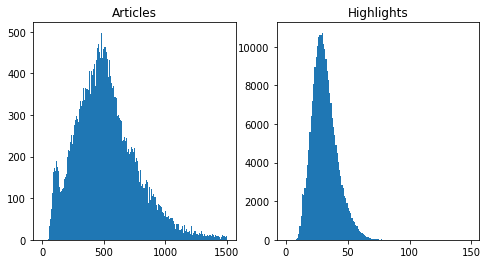

\begin{table}[htb]
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|l|}
			\hline
			Dataset & Mean & Median & Standard Deviation & Min & Max\\
			\hline\hline
			Articles & 534.44 & 495 & 283.47 & 47 & 5786 \\
			Highlights & 30.90 & 30 & 10.08 & 6 & 216 \\
			\hline
		\end{tabular}
		\caption{Word count of the sueddeutsche dataset}\label{tab_word_count_suedd}
	\end{center}
\end{table}


In [13]:
def plot_show(name, count_a, count_h):
    print("--- %s ---" % name)
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    
    axs[0].hist(count_a, range(0,1500))
    axs[0].set_title("Articles")
    axs[1].hist(count_h, range(0,150))
    axs[1].set_title("Highlights")
    plt.show()
    table_dict = {
        "Dataset": ["Articles", "Highlights"],
        "Mean": [np.mean(count_a), np.mean(count_h)],
        "Median": [int(np.median(count_a)), int(np.median(count_h))],
        "Standard Deviation": [np.std(count_a), np.std(count_h)],
        "Min": [int(np.min(count_a)), int(np.min(count_h))],
        "Max": [int(np.max(count_a)), int(np.max(count_h))]
    }
    print(latex_table_writer.write_table(name + " of the sueddeutsche dataset", table_dict, name.replace(" ", "_").lower() + "_suedd"))
plot_show("Word count", a_count, h_count)
# plot_show("Word Count", train_a_count, train_h_count)

In [14]:
train_a_count, train_h_count = count_tokens(train_articles, train_highlights)
val_a_count, val_h_count = count_tokens(val_articles, val_highlights)
test_a_count, test_h_count = count_tokens(test_articles, test_highlights)

Token indices sequence length is longer than the specified maximum sequence length for this model (872 > 512). Running this sequence through the model will result in indexing errors


In [15]:
a_count = np.concatenate([train_a_count, val_a_count, test_a_count])
h_count = np.concatenate([train_h_count, val_h_count, test_h_count])

--- Token Count ---


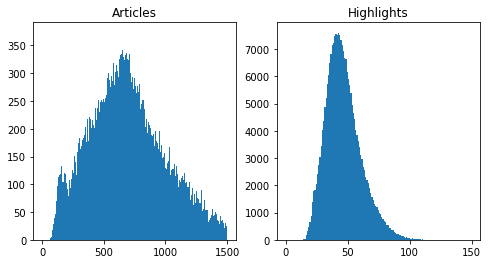

\begin{table}[htb]
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|l|}
			\hline
			Dataset & Mean & Median & Standard Deviation & Min & Max\\
			\hline\hline
			Articles & 741.88 & 685 & 399.35 & 62 & 8158 \\
			Highlights & 45.91 & 44 & 14.22 & 12 & 318 \\
			\hline
		\end{tabular}
		\caption{Token Count of the sueddeutsche dataset}\label{tab_token_count_suedd}
	\end{center}
\end{table}


In [16]:
plot_show("Token Count", a_count, h_count)
# plot_show("Token Count", train_a_count, train_h_count)

In [17]:
# from spacy.lang.de import German 
from spacy.lang.en import English 


nlp = English()
nlp.add_pipe('sentencizer')


def split_in_sentences(text):
    doc = nlp(text)
    return [str(sent).strip() for sent in doc.sents]

In [18]:
split_in_sentences("This is a test. What is that?")

['This is a test.', 'What is that?']

In [19]:
def count_sent_ds(ds):
    word_count = np.zeros(len(ds))
    
    for i, line in enumerate(ds):

        word_count[i] = len(split_in_sentences(line))
    return word_count     
    

def count_sent(articles, highlights):
    word_a = count_sent_ds(articles)
    word_h = count_sent_ds(highlights)
    
    return word_a, word_h

def plot_show(name, count_a, count_h):
    print("--- %s ---" % name)
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    
    axs[0].hist(count_a, range(0,150))
    axs[0].set_title("Articles")
    axs[1].hist(count_h, range(0,15))
    axs[1].set_title("Highlights")
    plt.show()
    table_dict = {
        "Dataset": ["Articles", "Highlights"],
        "Mean": [np.mean(count_a), np.mean(count_h)],
        "Median": [int(np.median(count_a)), int(np.median(count_h))],
        "Standard Deviation": [np.std(count_a), np.std(count_h)],
        "Min": [int(np.min(count_a)), int(np.min(count_h))],
        "Max": [int(np.max(count_a)), int(np.max(count_h))]
    }
    print(latex_table_writer.write_table("Word count of the sueddeutsche dataset", table_dict ,"tab_word_count_suedd"))


In [20]:
train_a_count, train_h_count = count_sent(train_articles, train_highlights)
val_a_count, val_h_count = count_sent(val_articles, val_highlights)
test_a_count, test_h_count = count_sent(test_articles, test_highlights)

a_count = np.concatenate([train_a_count, val_a_count, test_a_count])
h_count = np.concatenate([train_h_count, val_h_count, test_h_count])


--- Sentence Count ---


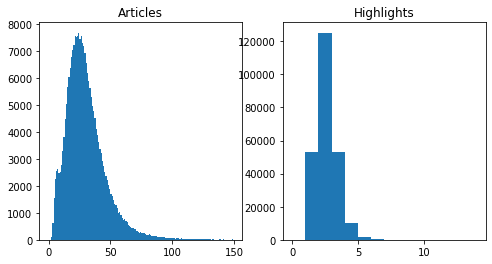

\begin{table}[htb]
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|l|}
			\hline
			Dataset & Mean & Median & Standard Deviation & Min & Max\\
			\hline\hline
			Articles & 29.76 & 27 & 16.99 & 1 & 507 \\
			Highlights & 2.11 & 2 & 0.82 & 1 & 12 \\
			\hline
		\end{tabular}
		\caption{Word count of the sueddeutsche dataset}\label{tab_tab_word_count_suedd}
	\end{center}
\end{table}


In [21]:
plot_show("Sentence Count", a_count, h_count)
# plot_show("Sentence Count", train_a_count, train_a_count)
